In [1]:
import torch
import numpy as np
from torchvision.datasets import MNIST
import torchvision.transforms as tf
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import imageio
from torch.utils.data import DataLoader as DL
import os

In [2]:
torch.cuda.is_available()
torch.manual_seed(1)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
device

'cuda'

MNIST Dataset

---

Import from `datasets`

In [5]:
transform = tf.Compose([tf.ToTensor(), tf.Normalize((0.1307), (0.3081,))])

In [6]:
train_ds = DL(MNIST(root="./data", train=True, download = True, transform= transform) ,batch_size=35)

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
test_ds = DL(MNIST(root="./data", train=False, download = True, transform= transform) ,batch_size = 35)

In [8]:
ind = iter(train_ds)

In [9]:
train_batches = len(ind)

In [10]:
class encoder(torch.nn.Module):
    def __init__(self, input_size, bottleneck):
        super().__init__()
        self.bn = bottleneck
        self.input_size = input_size
        self.fc1 = nn.Linear(input_size,bottleneck*2)
        self.fc2 = nn.Linear(bottleneck*2, bottleneck)
    
    def forward(self,x):
        m = torch.flatten(x, 1)
        return(self.fc2(self.fc1(m)))      

In [11]:
class decoder(torch.nn.Module):
    def __init__(self,bottleneck,output_size):
        super().__init__()
        self.bn = bottleneck
        self.fc1 = nn.Linear(bottleneck, bottleneck*2)
        self.fc2 = nn.Linear(bottleneck*2, output_size)
    def forward(self, x):
        return (self.fc2(self.fc1(x)))

In [12]:
ec = encoder(784,20)
dc =  decoder(20, 784)
dc

decoder(
  (fc1): Linear(in_features=20, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=784, bias=True)
)

In [13]:
class Autoencoder(torch.nn.Module):
    def __init__(self, input_size, bottleneck):
        super().__init__()
        self.bn = bottleneck
        self.input_size = input_size
        self.encoder = encoder(self.input_size, self.bn)
        self.decoder = decoder(self.bn, self.input_size)
    def forward(self,x):
        return self.decoder(self.encoder(x))
    

In [14]:
loss_fn = torch.nn.MSELoss()

In [15]:
y = next(ind)

In [16]:
y[0].shape

torch.Size([35, 1, 28, 28])

In [17]:
y[1]

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0])

In [18]:
img = torch.randn(35, 1, 28, 28)
op = ec(img)
print(op.shape)

torch.Size([35, 20])


In [19]:
ae = Autoencoder(784,32)

In [20]:
train_losses = []
test_losses = []
opt =  torch.optim.Adam(ae.parameters(), lr  = 0.001)

In [21]:
ae.to(device)

Autoencoder(
  (encoder): encoder(
    (fc1): Linear(in_features=784, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): decoder(
    (fc1): Linear(in_features=32, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=784, bias=True)
  )
)

In [22]:
torch.cuda.memory_allocated()

422912

In [22]:
def calc_loss(dl,model):
    model.eval()
    loss = 0
    count = 0
    for index,(image, target) in enumerate(dl):
        image = image.to(device)
        flat_img = torch.flatten(image, 1)
        loss = loss + loss_fn(model(image), flat_img).item()
        count = count + 1
    return loss/count

In [23]:
calc_loss(test_ds, ae)
print(calc_loss(train_ds, ae))

1.019876085877766


In [24]:
len(train_ds.dataset)

60000

In [25]:
for epoch in tqdm(range(3)):
    for index,(image, target) in (enumerate(tqdm(train_ds, leave=True))):
        ae.train()
        opt.zero_grad()
        ae = ae.to(device)
        image = image.to(device)
        flat_img = torch.flatten(image, 1)
        op = ae(image)
        loss = loss_fn(op, flat_img)
        loss.backward()
        opt.step()
        if(index %600 == 0):
            train_losses.append(loss.item())
            test_loss = calc_loss(test_ds, ae)
            test_losses.append(test_loss)


100%|██████████| 3/3 [00:56<00:00, 18.68s/it]


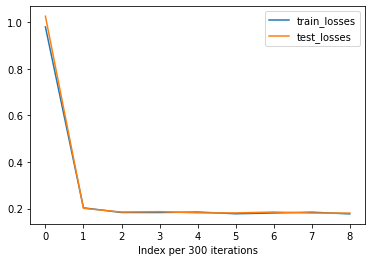

In [26]:
plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label= 'test_losses')
plt.xlabel('Index per 300 iterations')
plt.legend()

In [27]:
test_losses[-1]
ae = ae.to("cpu")
ae.eval()

Autoencoder(
  (encoder): encoder(
    (fc1): Linear(in_features=784, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): decoder(
    (fc1): Linear(in_features=32, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=784, bias=True)
  )
)

In [28]:
batch  = next(ind)
img = batch[0]

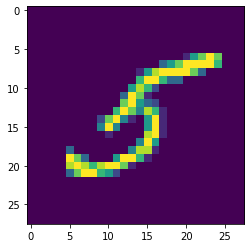

In [29]:
plt.imshow(img[0].permute(1, 2, 0))

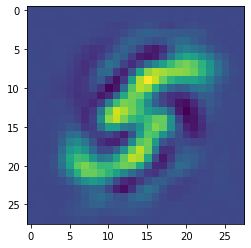

In [30]:
plt.imshow(ae(img[0]).reshape(-1,28,28).permute(1,2,0).detach().numpy())
latent = ae.encoder(img[0])

#### Using the model to visualize the Manifold structure in the latent space

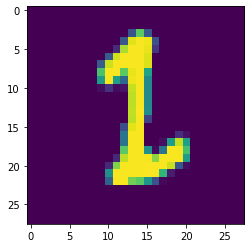

In [31]:
batch_next = next(ind)
image_next = batch_next[0]
plt.imshow(image_next[0].permute(1, 2, 0))
latent_next = ae.encoder(image_next[0])

In [32]:
# obtain the latent representations of both of the images
detacher = lambda x: torch.reshape(x, (-1, 28, 28)).detach().numpy()
imager = lambda x: torch.reshape(x, (-1, 28, 28)).permute(1, 2, 0).detach().numpy()
det_trans = tf.Lambda(detacher) 
image_trans = tf.Lambda(imager)

In [36]:
!mkdir images

mkdir: cannot create directory ‘images’: File exists


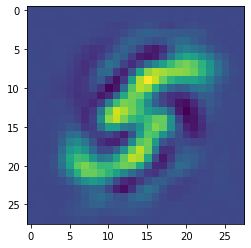

In [37]:
filenames = []
count = 0
for alpha in np.linspace(0,1, 60):
    count = count + 1
    latent_mid = alpha*latent + (1 - alpha)*latent_next
    plt.imshow(image_trans(ae.decoder(latent_mid)))
    plt.savefig('images/alpha_' + str(count) + '.png')
    filenames.append('images/alpha_' + str(count) + '.png')

In [38]:
images = []
for file in filenames:
    images.append(imageio.v2.imread(file))
    
imageio.mimsave('ae.gif', images)

![](ae.gif)

In [39]:
for file in filenames:
    os.remove(file)